Mean Squared Error (MSE): 3.643046597590805
Root Mean Squared Error (RMSE): 1.9086766613522588
Mean Absolute Error (MAE): 1.5769230175120907
R-squared (R²) Score: 0.9057162032514925
Mean Absolute Percentage Error (MAPE): 2.1996047838509876%


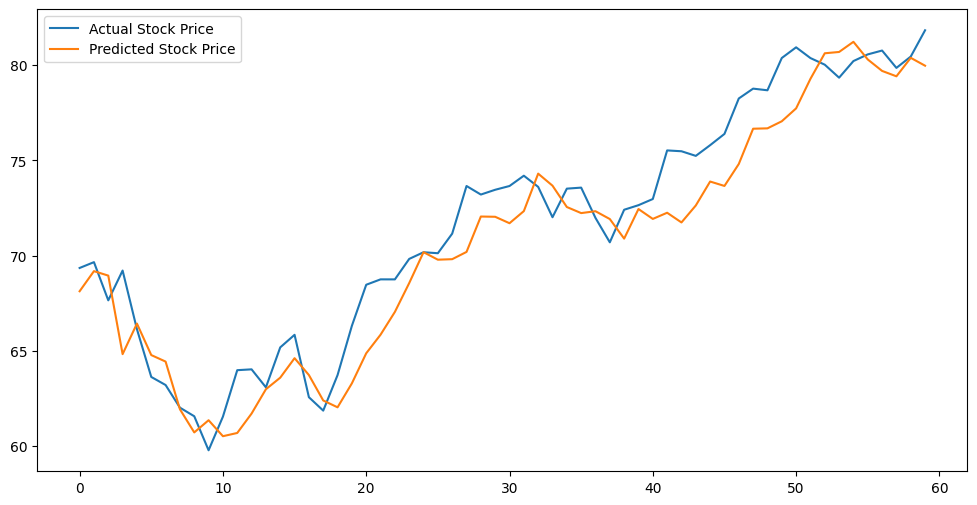

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Load and preprocess the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'fear-greed']].values  # Include 'fear-greed'
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 3])  # Index 3 corresponds to the 'Close' price
    x = np.array(x)
    y = np.array(y)
    return x.reshape(x.shape[0], -1), y  # Reshape x to 2D for SVM input

file_path = 'dataset.csv'  # Replace with your dataset
data, scaler = load_data(file_path)

time_step = 60  # Number of time steps to look back
x, y = create_dataset(data, time_step)

# Split data into train, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=train_size, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_size/(test_size + val_size), shuffle=False)

# Define the SVM model with GridSearchCV for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['rbf', 'linear']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
predictions = best_model.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], data.shape[1]-1)), predictions.reshape(-1, 1)], axis=1))[:, -1]

# Inverse transform y_test
y_test = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

# Optional: Visualize predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price')
plt.plot(predictions, label='Predicted Stock Price')
plt.legend()
plt.show()